In [44]:
from IPython.core.display import HTML
css_file = 'numericalmoocstyle.css'
HTML(open(css_file, 'r').read())

## Module 1 (Lorena Barba's Numerical MOOC with Python)

### Phugoid Motion


In [4]:
#phugoid motion plot flight code taken from course files

"""
Implementation of the functions to compute and plot the flight path of the
phugoid using Lanchester's mode.
The implementation uses the sign convention and formula provided by
Milne-Thomson (1958).
"""

import numpy
from matplotlib import pyplot


# Ignore over/underflow errors that pop up in the `radius_of_curvature`
# function.
# (See http://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html
# for more explanations.)
numpy.seterr(all='ignore')


def radius_of_curvature(z, zt, C):
    """
    Returns the radius of curvature of the flight path at any point.

    Parameters
    ----------
    z : float
        Current depth below the reference horizontal line.
    zt : float
        Initial depth below the reference horizontal line.
    C : float
        Constant of integration.

    Returns
    -------
    radius : float
        Radius of curvature.
    """
    return zt / (1 / 3 - C / 2 * (zt / z)**1.5)


def rotate(coords, center=(0.0, 0.0), angle=0.0, mode='degrees'):
    """
    Rotates a point or an array of points
    by a given angle around a given center point.

    Parameters
    ----------
    coords :tuple
        Current x and z positions of the point(s)
        as a tuple of two floats or a tuple of two 1D arrays of floats.
    center : tuple, optional
        Center of rotation (x, z) as a tuple of two floats;
        default: (0.0, 0.0).
    angle : float, optional
        Angle of rotation;
        default: 0.0.
    mode : string, optional
        Set if angle given in degrees or radians;
        choices: ['degrees', 'radians'];
        default: 'degrees'.

    Returns
    -------
    x_new : float or numpy.ndarray
        x position of the rotated point(s)
        as a single float or a 1D array of floats.
    z_new : float or numpy.ndarray
        z position of the rotated point(s)
        as a single float or a 1D array of floats.
    """
    x, z = coords
    xc, zc = center
    if mode == 'degrees':
        angle = numpy.radians(angle)
    x_new = xc + (x - xc) * numpy.cos(angle) + (z - zc) * numpy.sin(angle)
    z_new = zc - (x - xc) * numpy.sin(angle) + (z - zc) * numpy.cos(angle)
    return x_new, z_new


def plot_flight_path(zt, z0, theta0, N=1000):
    """
    Plots the flight path of the glider.

    Parameters
    ----------
    zt : float
        Trim height of the glider.
    z0 : float
        Initial height of the glider.
    theta0 : float
        Initial orientation of the glider (in degrees).
    N : integer, optional
        Number of points used to discretize the path;
        default: 1000.
    """
    # Convert initial angle to radians.
    theta0 = numpy.radians(theta0)
    # Create arrays to store the coordinates of the flight path.
    x, z = numpy.zeros(N), numpy.zeros(N)
    # Set initial conditions.
    x[0], z[0], theta = 0.0, z0, theta0
    # Calculate the constant of integration C.
    C = (numpy.cos(theta) - 1 / 3 * z[0] / zt) * (z[0] / zt)**0.5
    # Set incremental distance along the flight path.
    ds = 1.0
    # Calculate coordinates along the path.
    for i in range(1, N):
        # We use a minus sign for the second coordinate of the normal vector
        # because the z-axis points downwards.
        normal = numpy.array([+ numpy.cos(theta + numpy.pi / 2.0),
                              - numpy.sin(theta + numpy.pi / 2.0)])
        # Get curvature radius and compute center of rotation.
        R = radius_of_curvature(z[i - 1], zt, C)
        center = numpy.array([x[i - 1], z[i - 1]]) + R * normal
        # Set angular increment.
        dtheta = ds / R
        # Calculate new position and update angle.
        x[i], z[i] = rotate((x[i - 1], z[i - 1]),
                            center=center, angle=dtheta, mode='radians')
        theta += dtheta
    # Set the font family and size to use for Matplotlib figures.
    pyplot.rcParams['font.family'] = 'serif'
    pyplot.rcParams['font.size'] = 16
    # Create Matplotlib figure.
    fig, ax = pyplot.subplots(figsize=(9.0, 4.0))
    ax.grid()
    ax.set_title(f'Flight path for $C={C:.3f}$\n' +
                 rf'($z_t={zt:.1f}$, $z_0={z0:.1f}$, ' +
                 rf'$\theta_0={numpy.degrees(theta0):.1f}^o$)')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$z$')
    ax.plot(x, -z, linestyle='-', linewidth=2.0)
    #ax.axis('scaled', adjustable='box')
    pyplot.show()
#%%
# attempting curves at different values of C

#plot_flight_path(16.0, 48.0, 0.0)

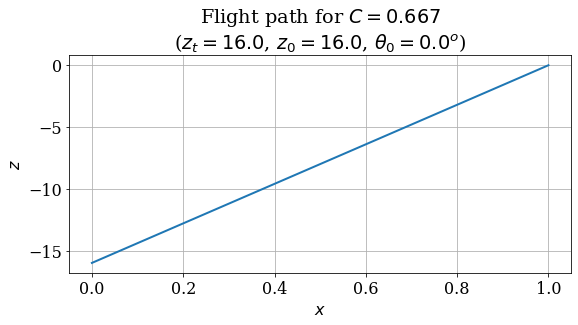

In [5]:
plot_flight_path(16.0,16.0,0.0)

#scroll down at the end of the code

The above plot shows that at C=2/3, zt/z = 1 and cos(theta)= 1, the plot of flight is a straight line (actually a curve with ROC = infinitty). Above, check code or values to obtain a horizontal straight lined path.

### Phugoid Oscillation and Euler's method of integration

In [6]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [7]:
# Create the time grid.
T = 100.0  # length of the time-interval
dt = 0.02  # time-step size
N = int(T / dt) + 1  # number of time steps
t = numpy.linspace(0.0, T, num=N)  # time grid
t2 = numpy.arange(0.0, T+dt, dt)

print(t, "\n", t2)

[0.000e+00 2.000e-02 4.000e-02 ... 9.996e+01 9.998e+01 1.000e+02] 
 [0.000e+00 2.000e-02 4.000e-02 ... 9.996e+01 9.998e+01 1.000e+02]


In [8]:
# Set the initial conditions.
z0 = 100.0  # altitude
b0 = 10.0  # upward velocity resulting from gust
zt = 100.0  # trim altitude
g = 9.81  # acceleration due to gravity

# Set the initial value of the numerical solution.
u = numpy.array([z0, b0])



# Create an array to store the elevation value at each time step.
z = numpy.zeros(N)
z[0] = z0
print(z)

[100.   0.   0. ...   0.   0.   0.]


In [9]:
# Temporal integration using Euler's method.
for n in range(1, N):
    rhs = numpy.array([u[1], g * (1 - u[0] / zt)]) 
    u = u + dt * rhs
    z[n] = u[0]
print(u)
print(z)

[96.64467925 10.98053405]
[100.         100.2        100.4        ...  96.20588732  96.42520884
  96.64467925]


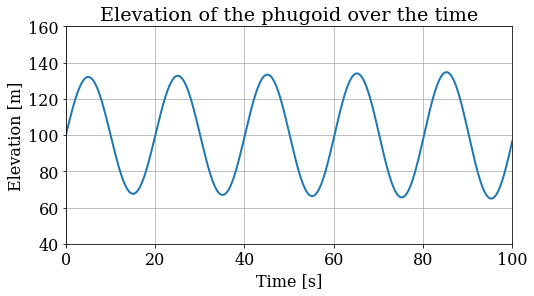

In [10]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

# Plot the solution of the elevation.
pyplot.figure(figsize=(8.0, 4.0))  # set the size of the figure
pyplot.title('Elevation of the phugoid over the time')  # set the title
pyplot.xlabel('Time [s]')  # set the x-axis label
pyplot.ylabel('Elevation [m]')  # set the y-axis label
pyplot.xlim(t[0], t[-1])  # set the x-axis limits
pyplot.ylim(40.0, 160.0)  # set the y-axis limits
pyplot.grid()  # set a background grid to improve readability
pyplot.plot(t, z, color='C0', linestyle='-', linewidth=2);

Below is my own code for the temporal intergration using Euler's method. The above code is better because it allows one to use a single line of code for multiple equations using the array u directly. 

The code below is easy for understanding. It also shows the effect of changing the values of the initial gust velocity. 

In [11]:
# Set the initial conditions.
my_z0 = 100.0  # altitude
my_b0_1 = 10.0  # upward velocity resulting from gust (1st value)
my_b0_2 = 20.0  # upward velocity resulting from gust (2nd value)
my_b0_3 = 0.0   # upward velocity resulting from gust (3rd value)
my_zt = 100.0  # trim altitude
g = 9.81  # acceleration due to gravity

# Set the initial value of the numerical solution.
my_u_1 = numpy.array([my_z0, my_b0_1])
my_u_2 = numpy.array([my_z0, my_b0_2])
my_u_3 = numpy.array([my_z0, my_b0_3])
# Create an array to store the elevation value at each time step.
my_z_1, my_z_2, my_z_3 = numpy.zeros(N), numpy.zeros(N), numpy.zeros(N)
my_z_1[0], my_z_2[0], my_z_3[0]  = my_z0, my_z0, my_z0
print(my_z_1, "\n", my_z_2, "\n", my_z_3)

[100.   0.   0. ...   0.   0.   0.] 
 [100.   0.   0. ...   0.   0.   0.] 
 [100.   0.   0. ...   0.   0.   0.]


In [12]:
for i in range(1,N):
    my_u_1[0], my_u_1[1] = my_u_1[0] + dt*my_u_1[1], my_u_1[1] + dt*(g - g*(my_u_1[0]/my_zt))
    my_z_1[i] = my_u_1[0]
    my_u_2[0], my_u_2[1] = my_u_2[0] + dt*my_u_2[1], my_u_2[1] + dt*(g - g*(my_u_2[0]/my_zt))
    my_z_2[i] = my_u_2[0]
    my_u_3[0], my_u_3[1] = my_u_3[0] + dt*my_u_3[1], my_u_3[1] + dt*(g - g*(my_u_3[0]/my_zt))
    my_z_3[i] = my_u_3[0]
print(my_z_1, "\n", my_z_2, "\n", my_z_3)

[100.         100.2        100.4        ...  96.20588732  96.42520884
  96.64467925] 
 [100.         100.4        100.8        ...  92.41177463  92.85041768
  93.28935849] 
 [100. 100. 100. ... 100. 100. 100.]


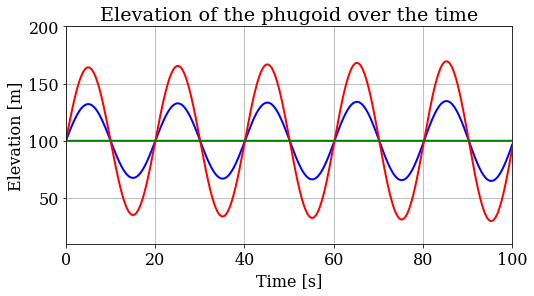

In [13]:
# Plot for my bit of code and variables named as my_(...)

# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

# Plot the solution of the elevation.
pyplot.figure(figsize=(8.0, 4.0))  # set the size of the figure
pyplot.title('Elevation of the phugoid over the time')  # set the title
pyplot.xlabel('Time [s]')  # set the x-axis label
pyplot.ylabel('Elevation [m]')  # set the y-axis label
pyplot.xlim(t[0], t[-1])  # set the x-axis limits
pyplot.ylim(10, 200)  # set the y-axis limits
pyplot.grid()  # set a background grid to improve readability
pyplot.plot(t, my_z_1, color='blue', linestyle='-', linewidth=2);
pyplot.plot(t, my_z_2, color='red', linestyle='-', linewidth=2);
pyplot.plot(t, my_z_3, color='green', linestyle='-', linewidth=2);

### Exact Solution
The equation for phugoid oscillations is a 2nd-order, linear ODE and it has an exact solution of the following form:

$$
\begin{equation}
z(t) = A \sin \left(\sqrt{\frac{g}{z_t}} t \right) + B \cos \left(\sqrt{\frac{g}{z_t}} t \right) + z_t
\end{equation}
$$

where $A$ and $B$ are constants that we solve for using initial conditions.  

Our numerical solution used the initial conditions:

$$
\begin{eqnarray}
z(0) = z_0 \\
b(0) = b_0
\end{eqnarray}
$$

Applying these to the exact solution and solving for $A$ and $B$, we get:

$$
\begin{equation}
z(t) = b_0 \sqrt{\frac{z_t}{g}} \sin \left(\sqrt{\frac{g}{z_t}} t \right) + (z_0-z_t) \cos \left(\sqrt{\frac{g}{z_t}} t \right) + z_t
\end{equation}
$$

In [14]:
z_exact = (b0 * (zt / g)**0.5 * numpy.sin((g / zt)**0.5 * t) +
           (z0 - zt) * numpy.cos((g / zt)**0.5 * t) + zt)

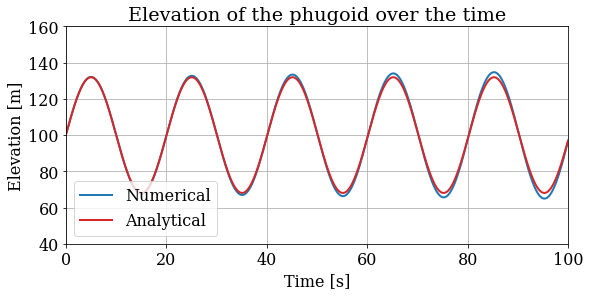

In [15]:
# Plot the numerical solution and the exact solution.
pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.title('Elevation of the phugoid over the time')  # set the title
pyplot.xlabel('Time [s]')  # set the x-axis label
pyplot.ylabel('Elevation [m]')  # set the y-axis label
pyplot.xlim(t[0], t[-1])  # set the x-axis limits
pyplot.ylim(40.0, 160.0)  # set the y-axis limits
pyplot.grid()  # set a background grid to improve readability
#plot of numerical solution
pyplot.plot(t, z, label='Numerical',
            color='C0', linestyle='-', linewidth=2)
#plot of exact solution
pyplot.plot(t, z_exact, label='Analytical',
            color='C3', linestyle='-', linewidth=2)
pyplot.legend();  # set the legend

### Covergence
Euler's method, like all numerical methods, introduces some errors.  If the method is *convergent*, the approximation will get closer and closer to the exact solution as we reduce the size of the step, $\Delta t$. The error in the numerical method should tend to zero, in fact, when $\Delta t\rightarrow 0$—when this happens, we call the method _consistent_. We'll define these terms more carefully in the theory components of this course. 

To compare the two solutions, we need to use a **norm** of the difference, like the $L_1$ norm, for example.

$$
E = \Delta t \sum_{n=0}^N \left|z(t_n) - z_n\right|
$$

The $L_1$ norm is the sum of the individual differences between the exact and the numerical solutions, at each mesh point. In other words, $E$ is the discrete representation of the integral over the interval $T$ of the (absolute) difference between the computed $z$ and $z_{\rm exact}$:

$$
E = \int \vert z-z_\rm{exact}\vert dt
$$

We check for convergence by calculating the numerical solution using progressively smaller values of `dt`. We already have most of the code that we need.  We just need to add an extra loop and an array of different $\Delta t$ values to iterate through.

In [16]:
# Set the list of time-step sizes.
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]

# Create an empty list that will contain the solution of each grid.
z_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time-steps
    t = numpy.linspace(0.0, T, num=N)  # time grid
    # Set the initial conditions.
    u = numpy.array([z0, b0])
    z = numpy.empty_like(t)
    z[0] = z0
    # Temporal integration using Euler's method.
    for n in range(1, N):
        rhs = numpy.array([u[1], g * (1 - u[0] / zt)])
        u = u + dt * rhs
        z[n] = u[0]  # store the elevation at time-step n+1
    z_values.append(z)  # store the elevation over the time. It stores separate arrays of z for each iteration of each dt value.


In [18]:
for i in z_values: 
    print(i)

[100.         101.         102.         ...  91.2989138   92.90712607
  94.5238741 ]
[100.         100.5        101.         ...  94.75726869  95.39076488
  96.02554684]
[100.         100.1        100.2        ...  96.60653005  96.71101708
  96.81553741]
[100.         100.05       100.1        ...  96.79319077  96.84418536
  96.89518782]
[100.         100.01       100.02       ...  96.93628874  96.94629199
  96.95629554]
[100.         100.001      100.002      ...  96.96774265  96.96873863
  96.9697346 ]


In [17]:
def l1_error(z, z_exact, dt):
    """
    Computes and returns the error
    (between the numerical and exact solutions)
    in the L1 norm.
    
    Parameters
    ----------
    z : numpy.ndarray
        The numerical solution as an array of floats.
    z_exact : numpy.ndarray
        The analytical solution as an array of floats.
    dt : float
        The time-step size.
        
    Returns
    -------
    error: float
        L1-norm of the error with respect to the exact solution.
    """
    error = dt * numpy.sum(numpy.abs(z - z_exact))
    #numpy.sum collapses the whole array to one single value.
    return error

**Note**: The numpy.sum causes the whole array to collapse in to one value. Thus, the numpy sum function has added all the values of abs(z - z_exact) together and returned one single value, which is the sum.

**Note**: in the first line of the function, we perform an 'array operation': 


In [18]:
# Create an empty list to store the errors on each time grid.
error_values = []

for z, dt in zip(z_values, dt_values):
    N = int(T / dt) + 1  # number of time-steps
    t = numpy.linspace(0.0, T, num=N)  # time grid
    # Compute the exact solution. We compute the z_exact value for each of the time steps corresponding to each dt value.
    z_exact = (b0 * (zt / g)**0.5 * numpy.sin((g / zt)**0.5 * t) +
               (z0 - zt) * numpy.cos((g / zt)**0.5 * t) + zt)
    # Calculate the L1-norm of the error for the present time grid.
    error_values.append(l1_error(z, z_exact, dt)) 
    print("z array for", str(dt), "is:", z, "\n")
    print("z_exact array for", str(dt), "is:", z_exact, "\n")
    print(error_values)

z array for 0.1 is: [100.         101.         102.         ...  91.2989138   92.90712607
  94.5238741 ] 

z_exact array for 0.1 is: [100.         100.99983651 101.99869226 ...  94.98748282  95.97737893
  96.97122091] 

[595.3673383328402]
z array for 0.05 is: [100.         100.5        101.         ...  94.75726869  95.39076488
  96.02554684] 

z_exact array for 0.05 is: [100.         100.49997956 100.99983651 ...  95.97737893  96.47386754
  96.97122091] 

[595.3673383328402, 272.677397541061]
z array for 0.01 is: [100.         100.1        100.2        ...  96.60653005  96.71101708
  96.81553741] 

z_exact array for 0.01 is: [100.         100.09999984 100.19999869 ...  96.77218359  96.8716869
  96.97122091] 

[595.3673383328402, 272.677397541061, 50.9668696233009]
z array for 0.005 is: [100.         100.05       100.1        ...  96.79319077  96.84418536
  96.89518782] 

z_exact array for 0.005 is: [100.         100.04999998 100.09999984 ...  96.8716869   96.92145013
  96.97122091] 


Remember, *if* the method is convergent then the error should get smaller as  $\Delta t$ gets smaller.  To visualize this, let's plot $\Delta t$ vs. error.  If you use `pyplot.plot` you won't get a very useful result.  Instead, use `pyplot.loglog` to create the same plot with a log-log scale.  This is what we do almost always to assess the errors of a numerical scheme graphically.

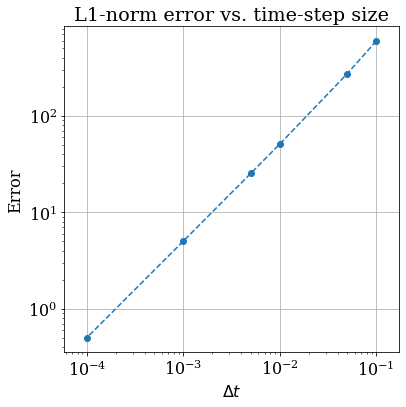

In [19]:
# Plot the error versus the time-step size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm error vs. time-step size')  # set the title
pyplot.xlabel('$\Delta t$')  # set the x-axis label
pyplot.ylabel('Error')  # set the y-axis label
pyplot.grid()
pyplot.loglog(dt_values, error_values,
              color='C0', linestyle='--', marker='o')  # log-log plot
pyplot.axis('equal');  # make axes scale equallyb